# Multi-Commodity Flow Formulation


#### Keywords: VRP,  Multi-Commodity Flow Formulation, IP, Gurobi, Python, Networkx

$ \text{Variables} $

$x_{ij} =
\begin{cases}
1 & \text{if a vehicle goes from node } i \text{ to node } j \\
0 & \text{otherwise}
\end{cases}
$

$f_{ij}^k$ is the flow of commodity $k$ on arc $(i, j)$  
$\mathcal{K}$ is the set of commodities (one per customer)  
$d_i^k$ is the demand of customer $i$ for commodity $k$  
$Q$ is the vehicle capacity


\begin{equation*}
\begin{aligned}
& \underset{}{\text{Minimize}} 
& & \sum_{i=0}^{n} \sum_{\substack{j=0 \\ j \ne i}}^{n} c_{ij} \cdot x_{ij} \\
& \text{Subject to} \\
& & \sum_{\substack{j=0 \\ j \ne i}}^{n} x_{ij} = 1, 
\quad \sum_{\substack{j=0 \\ j \ne i}}^{n} x_{ji} = 1,
\quad \forall i = 1, \ldots, n, \\
& & \sum_{j=1}^{n} x_{0j} = K, 
\quad \sum_{i=1}^{n} x_{i0} = K, \\
& & \sum_{j=0}^{n} f_{ij}^k - \sum_{j=0}^{n} f_{ji}^k = d_i^k,
\quad \forall i = 1, \ldots, n,\; \forall k \in \mathcal{K}, \\
& & \sum_{k \in \mathcal{K}} f_{ij}^k \le Q \cdot x_{ij}, 
\quad \forall i,j = 0, \ldots, n, \\
& & x_{ij} \in \{0,1\}, 
\quad f_{ij}^k \in \mathbb{R}_+.
\end{aligned}
\end{equation*}


##  Import Library and Model Enviroment

In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
m = gp.Model("VRP_MultiCommodity")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13


### Create Data and Matrix of Distances

In [2]:
n = 24  # number of customers
K = 4  # number of vehicles
Q = 15 # Capacity of vehicle
d = [0] + list(np.random.randint(1, Q // 4 + 1, size=n))  # demands (0 for depot)

# We treat each customer as a separate commodity => 1 commodity per customer.
# Commodity set = {1, 2, 3, 4, 5} for 5 customers
commodities = range(1, n+1)
#Create a Random Matrix
c = np.random.randint(1, 100, size=(n+1, n+1))
# A_i,i = 0
np.fill_diagonal(c, 0)

### Variables

In [3]:
x = m.addVars(n+1, n+1, vtype=GRB.BINARY, name="x")
f = m.addVars(n+1, n+1, commodities, vtype=GRB.CONTINUOUS, lb=0, name="f")

## Mathematical Model of VRP (MTZ Formulation)

### Objective Function

In [4]:
m.setObjective(gp.quicksum(c[i][j]*x[i,j] for i in range(n+1) for j in range(n+1) if i != j),GRB.MINIMIZE)

### Subject to:

In [5]:
# 1) Each customer in-degree/out-degree = 1
for i in range(1, n+1):
    m.addConstr(gp.quicksum(x[i,j] for j in range(n+1) if j != i) == 1)
    m.addConstr(gp.quicksum(x[j,i] for j in range(n+1) if j != i) == 1)

In [7]:
# 2) Depot constraints
m.addConstr(gp.quicksum(x[0,j] for j in range(1, n+1)) == K)
m.addConstr(gp.quicksum(x[i,0] for i in range(1, n+1)) == K)

<gurobi.Constr *Awaiting Model Update*>

In [8]:
# 3) Flow conservation for each commodity
for k in commodities:
    for i in range(1, n+1):
        # If i == k, net outflow - inflow = d[i], else 0
        demand_i_k = d[i] if i == k else 0
        m.addConstr(
            gp.quicksum(f[i,j,k] for j in range(n+1)) 
            - gp.quicksum(f[j,i,k] for j in range(n+1)) 
            == demand_i_k
        )

In [9]:
# 4) Capacity constraint: sum of all commodities <= Q if x[i,j] = 1
for i in range(n+1):
    for j in range(n+1):
        if i != j:
            m.addConstr(gp.quicksum(f[i,j,k] for k in commodities) <= Q * x[i,j])


### Solve the VRP (Flow-Based Formulation)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1226 rows, 15625 columns and 43848 nonzeros
Model fingerprint: 0xce54d32a
Variable types: 15000 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 0 rows and 625 columns
Presolve time: 0.10s
Presolved: 1226 rows, 15000 columns, 43848 nonzeros
Variable types: 14400 continuous, 600 integer (600 binary)

Root relaxation: objective 2.374000e+02, 3485 iterations, 0.22 seconds (0.37 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  237.40000  

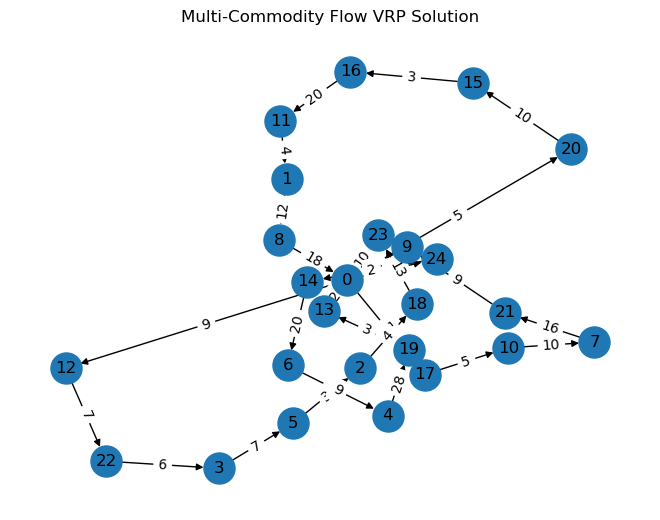

Optimal cost: 249.0
Vehicle route from 0 to 12
Vehicle route from 0 to 17
Vehicle route from 0 to 20
Vehicle route from 0 to 24
Vehicle route from 1 to 8
Vehicle route from 2 to 18
Vehicle route from 3 to 5
Vehicle route from 4 to 19
Vehicle route from 5 to 2
Vehicle route from 6 to 4
Vehicle route from 7 to 21
Vehicle route from 8 to 0
Vehicle route from 9 to 0
Vehicle route from 10 to 7
Vehicle route from 11 to 1
Vehicle route from 12 to 22
Vehicle route from 13 to 0
Vehicle route from 14 to 6
Vehicle route from 15 to 16
Vehicle route from 16 to 11
Vehicle route from 17 to 10
Vehicle route from 18 to 23
Vehicle route from 19 to 13
Vehicle route from 20 to 15
Vehicle route from 21 to 9
Vehicle route from 22 to 3
Vehicle route from 23 to 0
Vehicle route from 24 to 14


In [10]:
m.optimize()

# -------------
# NetworkX Plot
# -------------
if m.status == GRB.OPTIMAL:
    sol_x = m.getAttr('x', x)
    
    G = nx.DiGraph()
    for i in range(n+1):
        G.add_node(i)
    for i in range(n+1):
        for j in range(n+1):
            if i != j and sol_x[i,j] > 0.5:
                G.add_edge(i, j)
    
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=500)
    edge_labels = {(i, j): c[i][j] for (i, j) in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Multi-Commodity Flow VRP Solution")
    plt.show()
    
    print("Optimal cost:", m.objVal)
    for i in range(n+1):
        for j in range(n+1):
            if i != j and sol_x[i,j] > 0.5:
                print(f"Vehicle route from {i} to {j}")

### Literature

Baldacci, R., Mingozzi, A., & Roberti, R. (2012). Recent exact algorithms for solving the vehicle routing problem
under capacity and time window constraints. European Journal of Operational Research, 218(1), 1-6.
https://doi.org/10.1016/j.ejor.2011.07.037